In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [2]:
import os
import random
from collections import defaultdict
import numpy as np
import shutil
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as iio  # Import imageio.v2 instead of imageio
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [3]:
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *

# 1. Data Preprocessing

## 1) 데이터 수 확인

In [4]:
import pandas as pd
import os

directory_path = '/content/drive/MyDrive/eardrum2/combined_data_2_png/train/'
folders = ['Normal', 'Abnormal']

# 이미지 파일과 레이블을 저장하기 위한 리스트
image_paths = []
labels = []

# 각 폴더(레이블)에 대해 반복
for folder in folders:
  folder_path = os.path.join(directory_path, folder)
  # 해당 폴더 내의 모든 파일에 대해 반복
  for filename in os.listdir(folder_path):
    # 파일 경로와 레이블을 리스트에 추가
    image_paths.append(os.path.join(folder_path, filename))
    labels.append(folder)

# DataFrame 생성
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# 데이터 확인
print(df.head())


                                          image_path   label
0  /content/drive/MyDrive/eardrum2/combined_data_...  Normal
1  /content/drive/MyDrive/eardrum2/combined_data_...  Normal
2  /content/drive/MyDrive/eardrum2/combined_data_...  Normal
3  /content/drive/MyDrive/eardrum2/combined_data_...  Normal
4  /content/drive/MyDrive/eardrum2/combined_data_...  Normal


- 파일 format 확인

In [5]:
def unique_file_formats_in_directory(directory_path):
    file_formats = {os.path.splitext(f)[1].lower() for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))}
    return file_formats

for folder in folders:
    path = directory_path + folder
    unique_formats = unique_file_formats_in_directory(path)
    print(folder, ":", unique_formats)

Normal : {'.png'}
Abnormal : {'.png'}


## 2) 데이터 분할 -> ※ 다시 실행 하지 말것!!!

In [ ]:
import os
import random
from collections import defaultdict

# Define the categories and their corresponding image counts
categories = {
    "Normal": 534,
    "AOM": 119,
    "CSOM": 63,
    "Earwax": 140,
    "OE": 41,
    "Tympanoskleros": 28
}

# Define the desired proportions for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the total number of images in the dataset
total_images = sum(categories.values())
print(total_images)

925


In [ ]:
import os
import numpy as np
import shutil

# Defining your directories
base_dir = '/content/drive/MyDrive/eardrum/data/'
base_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir)]

train_dir = '/content/drive/MyDrive/eardrum/new_data/train'
val_dir = '/content/drive/MyDrive/eardrum/new_data/val'
test_dir = '/content/drive/MyDrive/eardrum/new_data/test'

In [ ]:
base_dirs

['/content/drive/MyDrive/eardrum/data/Earwax',
 '/content/drive/MyDrive/eardrum/data/Normal',
 '/content/drive/MyDrive/eardrum/data/CSOM',
 '/content/drive/MyDrive/eardrum/data/AOM',
 '/content/drive/MyDrive/eardrum/data/OE',
 '/content/drive/MyDrive/eardrum/data/Tympanoskleros']

In [ ]:
# Ratio of splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate over all directories (classes) in your base directory
for dir_path in base_dirs: # -> 1분 40초 소요
    class_name = os.path.basename(dir_path)

    # Create corresponding directories in train, val, test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all file names and shuffle them
    files = os.listdir(dir_path)
    np.random.shuffle(files)

    # Calculate split indices
    train_idx = int(len(files) * train_ratio)
    val_idx = int(len(files) * (train_ratio + val_ratio))

    # Split file names
    train_files = files[:train_idx]
    val_files = files[train_idx:val_idx]
    test_files = files[val_idx:]

    # Move files to corresponding directories
    for file_name in train_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(train_dir, class_name, file_name))

    for file_name in val_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(val_dir, class_name, file_name))

    for file_name in test_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(test_dir, class_name, file_name))

In [ ]:
new_data_path = '/content/drive/MyDrive/eardrum/new_data/'

folders = ['Normal', 'AOM', 'CSOM', 'Earwax', 'OE', 'Tympanoskleros']

print("Train Set:")
for folder in folders:
  path = new_data_path + 'train/'+folder
  print(folder, ':', count_files_in_directory(path))

print("\nVal Set:")
for folder in folders:
  path = new_data_path + 'val/'+folder
  print(folder, ':', count_files_in_directory(path))

print("\nTest Set:")
for folder in folders:
  path = new_data_path + 'test/'+folder
  print(folder, ':', count_files_in_directory(path))

Train Set:
Normal : 373
AOM : 83
CSOM : 44
Earwax : 98
OE : 28
Tympanoskleros : 19

Val Set:
Normal : 80
AOM : 18
CSOM : 9
Earwax : 21
OE : 6
Tympanoskleros : 4

Test Set:
Normal : 81
AOM : 18
CSOM : 10
Earwax : 21
OE : 7
Tympanoskleros : 5


## 3) ImageDataGenerator

- 임의로 뽑아서 시각화

In [9]:
train_dir = '/content/drive/MyDrive/eardrum2/data_2_kfold/train'
test_dir = '/content/drive/MyDrive/eardrum2/data_2_kfold/test'

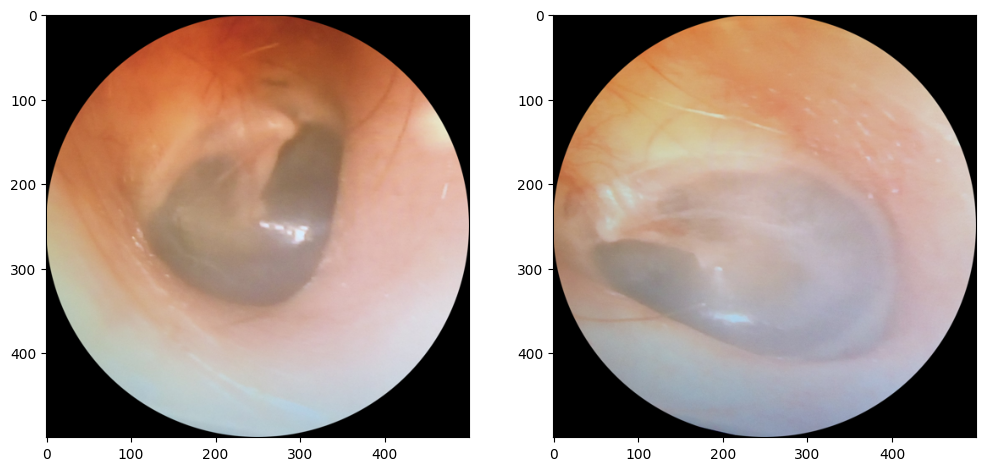

In [10]:
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as iio  # Import imageio.v2 instead of imageio

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Load the TIFF image using imageio.v2
img = iio.imread(train_dir + '/Normal/normal_1.png')
axes[0].imshow(img)

img = iio.imread(train_dir + '/Normal/normal_2.png')
axes[1].imshow(img)

plt.show()

In [11]:
img.shape

(500, 500, 3)

- image shape : (500, 500, 3)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# 고막 내시경에 적합한 데이터 증강 방법 적용 -> 수정할 것
train_datagen = ImageDataGenerator(
                                  rotation_range=40,           # 랜덤하게 이미지 회전 각도 설정 (0~40도 사이)
                                  horizontal_flip=True,          # 수평 방향으로 랜덤하게 이미지 뒤집기
                                  vertical_flip=True,            # 수직 방향으로 랜덤하게 이미지 뒤집기
                                  zoom_range=(0.8, 1),           # 랜덤하게 확대/축소 범위 설정, 0.7: 확대, 1: 원본크기와 동일
                                  #  shear_range = 0.2,           # 랜덤 전단 변환 범위 설정
                                  #  fill_mode = 'nearest',       # 이동으로 인한 빈 픽셀을 가장 가까운 값으로 채우는 방식
                                  brightness_range=[0.7, 1.3],  # 명도 범위
                                  rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale=1./255)

- image size 수정? -> (448, 448)
- batch size 수정? -> 16? 8?

In [14]:
from sklearn.model_selection import StratifiedKFold
# 데이터 생성기 설정
datagen = ImageDataGenerator(rescale=1./255)

# StratifiedKFold 객체를 생성한다
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

- 데이터 증강된 이미지 확인해보기

# 2. Model

In [15]:
SHAPE = (224, 224, 3)
BATCH_SIZE = 16
EPOCHS = 50
TOTAL_CLASS_NUMBER = 2 # 2, 3

In [16]:
from keras import backend as K

In [17]:
class SGDRScheduler(Callback):
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [18]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

- ReduceLROnPlateau:
  - 검증 손실(val_loss)이 10번의 에포크(patience)동안 향상되지 않으면 학습률(learning rate)을 0.1배(factor)로 감소시킵니다.
  - 이는 학습 도중 학습률을 동적으로 조절하여 학습을 안정화시키는 데 사용됩니다.
- EarlyStopping:
  - 검증 손실(val_loss)이 20번의 에포크(patience)동안 향상되지 않으면 학습을 조기에 종료합니다.
  - 이를 통해 과적합을 방지하고 효율적인 학습을 할 수 있습니다.
- ModelCheckpoint:
  - 검증 손실(val_loss)이 가장 낮을 때 모델을 저장합니다.
  - 이를 통해 최상의 성능을 보이는 모델을 저장하여 나중에 재사용할 수 있습니다.

In [19]:
# import math

# num_other = 160
# num_normal = 534

# # 전체 샘플 수
# total_samples = num_normal + num_other

# # 클래스별 비율 계산
# ratio_normal = num_normal / total_samples
# ratio_other = num_other / total_samples

# # 클래스별 가중치 계산
# weight_normal = math.sqrt(1 / ratio_normal)
# weight_other = math.sqrt(1 / ratio_other)

# # 클래스별 가중치 출력
# print("Normal class weight:", weight_normal)
# print("Other class weight:", weight_other)

# # 클래스별 가중치를 딕셔너리로 변환
# class_weights = {
#     0: weight_normal,
#     1: weight_other
# }

In [23]:
import math

num_other = 160
num_normal = 534

# 전체 샘플 수
total_samples = num_normal + num_other

# 클래스별 비율 계산
ratio_normal = num_normal / total_samples
ratio_other = num_other / total_samples

# 클래스별 가중치 계산
weight_normal = math.sqrt(math.sqrt(math.sqrt(1/ratio_normal)))
weight_other =math.sqrt(math.sqrt(math.sqrt(1/ratio_other)))



# 클래스별 가중치 출력
print("Normal class weight:", weight_normal)
print("Other class weight:", weight_other)

# 클래스별 가중치를 딕셔너리로 변환
class_weights = {
    0: weight_other,
    1: weight_normal
}

Normal class weight: 1.033302015923927
Other class weight: 1.2013095676885543


In [24]:
# 활성 세션 내 모델 저장소 디렉토리 생성
os.makedirs('/content/model/')

In [25]:
schedule = SGDRScheduler(min_lr=1e-6,
                         max_lr=1e-3,
                         steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                         lr_decay=0.9,
                         cycle_length=10,
                         mult_factor=2.)

In [26]:
# ModelCheckpoint 콜백 설정
fold_var = 1
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'model_fold_{fold_var}.h5',  # 파일 경로 및 이름
    save_best_only=True,  # True면 모델의 정확도가 개선되었을 때만 저장
    monitor='val_loss',  # 'val_loss'를 모니터링하여 개선될 때 저장
    mode='min',  # 'min' 모드는 'val_loss'가 감소할 때 모델을 저장
    verbose=1  # 1로 설정하면 언제 모델을 저장하는지 출력
)

In [27]:
X = df['image_path'].values  # 이미지 경로
y = df['label'].values  # 레이블

In [28]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [29]:
for train_index, val_index in kf.split(X, y):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=None,
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=16,
        shuffle=True,
        seed=42)

    validation_generator = test_datagen.flow_from_dataframe(
        dataframe=validation_data,
        directory=None,
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=16,
        shuffle=True,
        seed=42)

    xception_model = Xception(weights = 'imagenet',
                          include_top = False,
                          input_shape = (224, 224, 3))

    x = GlobalAveragePooling2D()(xception_model.output)
    x = Dense(256, activation = 'relu')(x)
    x = Dense(2, activation = 'softmax')(x)  # Modify the final Dense layer based on your specific problem

    model = Model(inputs = xception_model.input, outputs = x)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[precision, recall, f1, 'acc'])


    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=40,  # 실제 상황에 맞게 조정할 것
        verbose=1,
        callbacks=[model_checkpoint_callback, schedule],
        class_weight=class_weights)

    # 필요하다면 모델 저장
    model.save(f'model_fold_{fold_var}.h5')
    fold_var += 1


Found 470 validated image filenames belonging to 2 classes.
Found 118 validated image filenames belonging to 2 classes.
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/40
30/30 [==============================] - ETA: 0s - loss: 0.6786 - precision: 0.7361 - recall: 0.7361 - f1: 0.7361 - acc: 0.7340
Epoch 1: val_loss improved from inf to 0.55004, saving model to model_fold_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 271s 8s/step - loss: 0.6786 - precision: 0.7361 - recall: 0.7361 - f1: 0.7361 - acc: 0.7340 - val_loss: 0.5500 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0.7712
Epoch 2/40
30/30 [==============================] - ETA: 0s - loss: 0.5065 - precision: 0.7681 - recall: 0.7681 - f1: 0.7681 - acc: 0.7702
Epoch 2: val_loss improved from 0.55004 to 0.40344, saving model to model_fold_1.h5
30/30 [==============================] - 12s 410ms/step - loss: 0.5065 - precision: 0.7681 - recall: 0.7681 - f1: 0.7681 - acc: 0.7702 - val_loss: 0.4034 - val_precision: 0.7891 - val_recall: 0.7891 - val_f1: 0.7891 - val_acc: 0.7712
Epoch 3/40
30/30 [==============================] - ETA: 0s - loss: 0.5607 - precision: 0.7861 - recall: 0.7861 - f1: 0.7861 - acc: 0.7851
Epoch 3: val_loss did not improve from 0.40344
30/30 [==============================] - 12s 400ms/step - loss: 0.5607 - precision: 0.7861 - recall: 0.7861 - f1: 0.7861 - ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 12s 410ms/step - loss: 0.4296 - precision: 0.8347 - recall: 0.8347 - f1: 0.8347 - acc: 0.8383 - val_loss: 0.3667 - val_precision: 0.8438 - val_recall: 0.8438 - val_f1: 0.8437 - val_acc: 0.8729
Epoch 11/40
30/30 [==============================] - ETA: 0s - loss: 0.4579 - precision: 0.8361 - recall: 0.8361 - f1: 0.8361 - acc: 0.8362
Epoch 11: val_loss did not improve from 0.36670
30/30 [==============================] - 12s 380ms/step - loss: 0.4579 - precision: 0.8361 - recall: 0.8361 - f1: 0.8361 - acc: 0.8362 - val_loss: 0.4868 - val_precision: 0.8828 - val_recall: 0.8828 - val_f1: 0.8828 - val_acc: 0.8729
Epoch 12/40
30/30 [==============================] - ETA: 0s - loss: 0.3832 - precision: 0.8583 - recall: 0.8583 - f1: 0.8583 - acc: 0.8660
Epoch 12: val_loss did not improve from 0.36670
30/30 [==============================] - 11s 375ms/step - loss: 0.3832 - precision: 0.8583 - recall: 0.8583 - f1: 0.8583 - acc: 0.8660 - val_loss: 1.2093 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 471 validated image filenames belonging to 2 classes.
Found 117 validated image filenames belonging to 2 classes.
Epoch 1/40
30/30 [==============================] - ETA: 0s - loss: 0.6446 - precision: 0.7682 - recall: 0.7682 - f1: 0.7682 - acc: 0.7665
Epoch 1: val_loss did not improve from 0.22089
30/30 [==============================] - 30s 278ms/step - loss: 0.6446 - precision: 0.7682 - recall: 0.7682 - f1: 0.7682 - acc: 0.7665 - val_loss: 0.6791 - val_precision: 0.7375 - val_recall: 0.7375 - val_f1: 0.7375 - val_acc: 0.7692
Epoch 2/40
30/30 [==============================] - ETA: 0s - loss: 0.6055 - precision: 0.7696 - recall: 0.7696 - f1: 0.7696 - acc: 0.7707
Epoch 2: val_loss did not improve from 0.22089
30/30 [==============================] - 11s 378ms/step - loss: 0.6055 - precision: 0.7696 - recall: 0.7696 - f1: 0.7696 - acc: 0.7707 - val_loss: 0.5956 - val_precision: 0.7375 - val_recall: 0.7375 - val_f1: 0.7375 - val_acc: 0.7692
Epoch 3/40
30/30 [======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 471 validated image filenames belonging to 2 classes.
Found 117 validated image filenames belonging to 2 classes.
Epoch 1/40
30/30 [==============================] - ETA: 0s - loss: 0.5423 - precision: 0.7655 - recall: 0.7655 - f1: 0.7655 - acc: 0.7665
Epoch 1: val_loss did not improve from 0.22089
30/30 [==============================] - 28s 200ms/step - loss: 0.5423 - precision: 0.7655 - recall: 0.7655 - f1: 0.7655 - acc: 0.7665 - val_loss: 0.6959 - val_precision: 0.7375 - val_recall: 0.7375 - val_f1: 0.7375 - val_acc: 0.7692
Epoch 2/40
30/30 [==============================] - ETA: 0s - loss: 0.4355 - precision: 0.8119 - recall: 0.8119 - f1: 0.8119 - acc: 0.8110
Epoch 2: val_loss did not improve from 0.22089
30/30 [==============================] - 12s 400ms/step - loss: 0.4355 - precision: 0.8119 - recall: 0.8119 - f1: 0.8119 - acc: 0.8110 - val_loss: 1.7146 - val_precision: 0.7453 - val_recall: 0.7453 - val_f1: 0.7453 - val_acc: 0.7778
Epoch 3/40
30/30 [======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Assuming the same rescaling was applied to the training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Replace the following path with the path to your test data
test_data_path = '/content/drive/MyDrive/eardrum2/combined_data_2_png/test/'

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),  # Make sure to match the input size of your model
    color_mode='rgb',  # or 'grayscale' depending on your model
    batch_size=16,  # Can be adjusted according to your needs
    class_mode='categorical',  # Use 'binary' for binary classification
    shuffle=False  # Important for maintaining order
)

# Note: If your test data is in a DataFrame, use flow_from_dataframe instead

Found 106 images belonging to 2 classes.


In [31]:
# Load the best model
best_model = load_model("/content/model_fold_1.h5",
                        custom_objects={'precision': precision,
                                          'recall': recall,
                                          'f1': f1})

# Evaluate the best model on test data
test_loss, test_precision, test_recall, test_f1, test_accuracy = best_model.evaluate(test_generator)

7/7 [==============================] - 43s 7s/step - loss: 0.4073 - precision: 0.8411 - recall: 0.8411 - f1: 0.8411 - acc: 0.8491


In [32]:
print("Test Loss: ", test_loss)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test F1: ", test_f1)
print("Test Accuracy: ", test_accuracy)

Test Loss:  0.4073318839073181
Test Precision:  0.8410714268684387
Test Recall:  0.8410714268684387
Test F1:  0.8410714268684387
Test Accuracy:  0.849056601524353


### ※ 세션 내에 모델 저장했을 경우, 드라이브에 모델 저장하기(선택)

In [ ]:
# 모델 저장

# 새로운 경로 설정
new_model_path = "/content/drive/MyDrive/eardrum/model/"

best_model.save(new_model_path + "att_model_2_class_증강_skfold_cost.h5") # 모델 이름 수정할 것

# 3. Check Model Performance

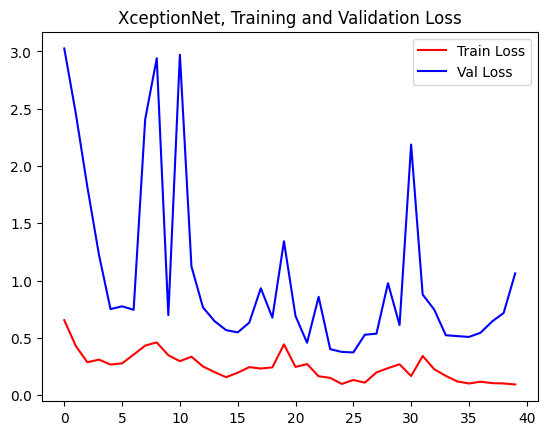

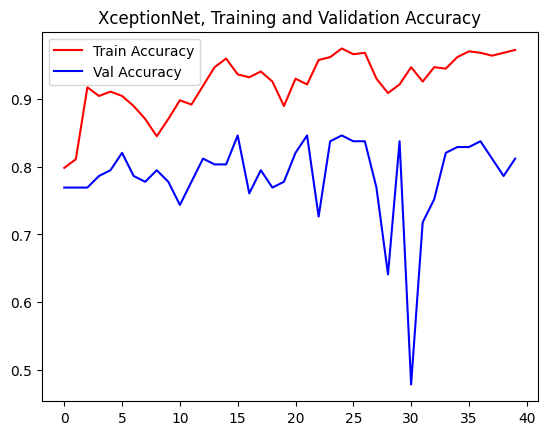

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], 'r', label = 'Train Loss')
plt.plot(history.history['val_loss'], 'b', label = 'Val Loss')
plt.title('XceptionNet, Training and Validation Loss')
plt.legend()

plt.show()

plt.plot(history.history['acc'], 'r', label = 'Train Accuracy')
plt.plot(history.history['val_acc'], 'b', label = 'Val Accuracy')
plt.title('XceptionNet, Training and Validation Accuracy')
plt.legend()

plt.show()

In [33]:
class_indices = train_generator.class_indices
# reversing the dictionary
index_class = {v: k for k, v in class_indices.items()}

In [34]:
index_class

{0: 'Abnormal', 1: 'Normal'}

In [35]:
y_pred = best_model.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis=1)

7/7 [==============================] - 2s 158ms/step


In [36]:
true_classes = test_generator.classes

In [37]:
error_indices = np.where(predicted_classes != true_classes)[0]

# test data에 대해 잘못 예측한 경우

In [45]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# let's say you want to see the first 5 misclassified images
for i in range(16):
    error_index = error_indices[i]

    img_path = test_generator.filepaths[error_index]
    img = image.load_img(img_path, target_size=(224, 224))  # assuming this was your input size

    true_label = index_class[true_classes[error_index]]
    predicted_label = index_class[predicted_classes[error_index]]

    plt.figure()
    plt.imshow(img)
    plt.title(f"True label: {true_label} \n Predicted label: {predicted_label}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Confusion Matrix

In [39]:
class_labels = list(test_generator.class_indices.keys())  # get the labels as a list

In [40]:
class_labels

['Abnormal', 'Normal']

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [42]:
conf_matrix

array([[17,  8],
       [ 8, 73]])

In [43]:
print(classification_report(true_classes, predicted_classes, digits=2))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        25
           1       0.90      0.90      0.90        81

    accuracy                           0.85       106
   macro avg       0.79      0.79      0.79       106
weighted avg       0.85      0.85      0.85       106



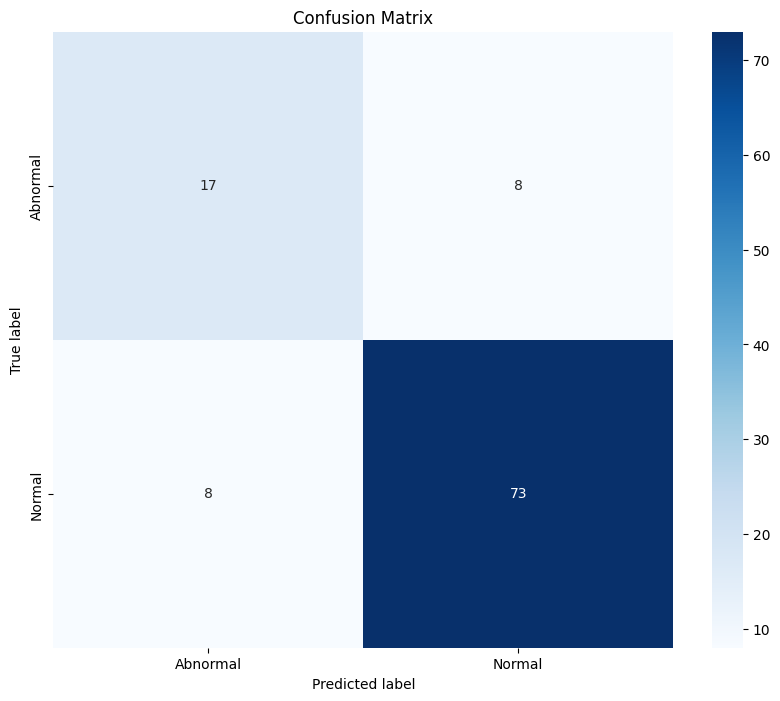

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# F1 score